# 1. Hopf Bifurcation

In [1]:
def rec_derivative(expr, *args):
    try:
        return derivative(expr, *args)
    except:
        return [rec_derivative(i, *args) for i in expr]
def rec_subs(expr, **kwargs):
    try:
        return expr.subs(**kwargs)
    except:
        return [rec_subs(i, **kwargs) for i in expr]
pp = pretty_print

In [2]:
var('r f alpha')
r_dot = (1 - r) * r - (r * f) / (3/10 + alpha * r)
f_dot = -f/2 + (r * f) / (3/10 + alpha * r)
equilibria = solve([r_dot == 0, f_dot == 0], r, f)
J = jacobian([r_dot, f_dot], (r, f))

In [3]:
pp(equilibria)

[[r == 0, f == 0], [r == 1, f == 0], [r == -3/10/alpha, f == 0], [r == -3/10/(alpha - 2), f == -3/50*(10*alpha - 17)/(alpha^2 - 4*alpha + 4)]]

## Origin stability

In [4]:
pp(J.subs(equilibria[0]))

[   1    0]
[   0 -1/2]

It's a saddle.

## Hopf bifurcations

The first two equilibrium points are trivial and don't depend on the control parameter. The third point is negative, given positive alpha, i.e. negative rabbits. The last equilibrium point is positive for $\alpha < 17/10$

In [5]:
del(equilibria[2])

In [6]:
eq = equilibria[-1]
pp(eq)

[r == -3/10/(alpha - 2), f == -3/50*(10*alpha - 17)/(alpha^2 - 4*alpha + 4)]

In [7]:
J_eq = J.subs(eq)
ev = J_eq.eigenvalues()
dev = rec_derivative(ev,alpha)

We need to check that the eigenvalues are a pair of conjugate purely imaginary values, and their derivative with respect to the control parameter has a non-zero real component.

In [8]:
print('Eigenvalues at alpha=0.5')
pp(rec_subs(ev,alpha=1/2))
print('Their respective derivatives wrt alpha at alpha=0.5')
pp(rec_subs(dev,alpha=1/2))

Eigenvalues at alpha=0.5


[1/10*sqrt(-30), -1/10*sqrt(-30)]

Their respective derivatives wrt alpha at alpha=0.5


[-1/24*sqrt(-30) + 7/60, 1/24*sqrt(-30) + 7/60]

In [9]:
print('Eigenvalues at alpha=1.2')
pp(rec_subs(ev,alpha=12/10))
print('Their respective derivatives wrt alpha at alpha=1.2')
pp(rec_subs(dev,alpha=12/10))

Eigenvalues at alpha=1.2


[1/4*sqrt(-2), -1/4*sqrt(-2)]

Their respective derivatives wrt alpha at alpha=1.2


[-1/4*sqrt(-2) - 7/32, 1/4*sqrt(-2) - 7/32]

As we can see, everything checks out. Now we need to show that they are supercritical.

### Sample trajectory starting from the equilibrium point with alpha between bifurcation points

/nix/store/vh8bw6vs0i9b0fn1hzh3x06k59yrkb7r-python3-3.12.7-env/lib/python3.12/site-packages/sage/plot/point.py:314: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  subplot.scatter(self.xdata, self.ydata, s=s, c=c, alpha=a, zorder=z,


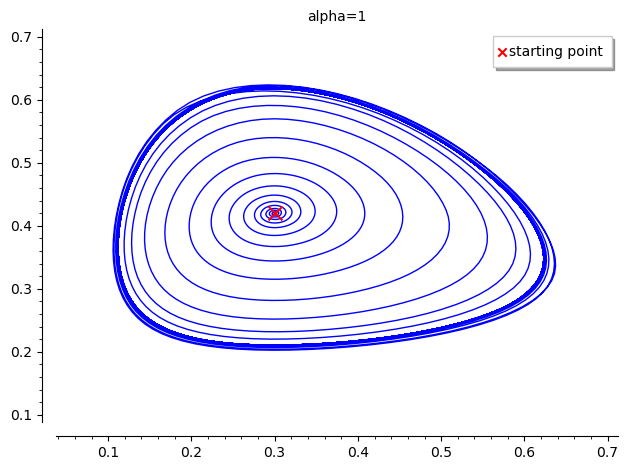

In [10]:
import numpy as np
from scipy.integrate import solve_ivp

def system(t, y, alpha):
    r, f = y
    dr_dt = (1 - r) * r - (r * f) / (0.3 + alpha * r)
    df_dt = -0.5 * f + (r * f) / (0.3 + alpha * r)
    return [dr_dt, df_dt]


def trajectory(alpha_value):
    t_span = (0, 1000)
    ic = [i.subs(alpha=alpha_value).rhs() for i in eq]
    t_eval = np.linspace(*t_span, 5000)
    sol = solve_ivp(system, t_span, ic, t_eval=t_eval, args=(alpha_value,))
    r_vals, f_vals = sol.y
    return line(zip(r_vals, f_vals), ymin=0.1, ymax=0.7, xmin=0.05, xmax=0.7, title=f'alpha={alpha_value}')

show(trajectory(1) + point([i.subs(alpha=1).rhs() for i in eq],
                           marker='x', color='red', size=100, zorder=10, legend_label='starting point'))

### Trajectories starting from the equilibrium point

/nix/store/vh8bw6vs0i9b0fn1hzh3x06k59yrkb7r-python3-3.12.7-env/lib/python3.12/site-packages/sage/plot/point.py:314: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  subplot.scatter(self.xdata, self.ydata, s=s, c=c, alpha=a, zorder=z,


Animation with 50 frames
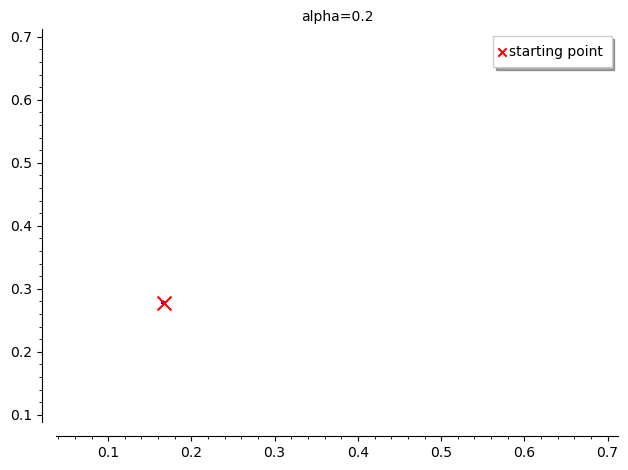

In [11]:
animate(
    [trajectory(alpha_value) +
     point([i.subs(alpha=alpha_value).rhs() for i in eq],
           marker='x', color='red', size=100, zorder=10, legend_label='starting point') for alpha_value in np.linspace(0.2,1.5,50)])

### Trajectory with linearly increasing alpha

Animation with 100 frames
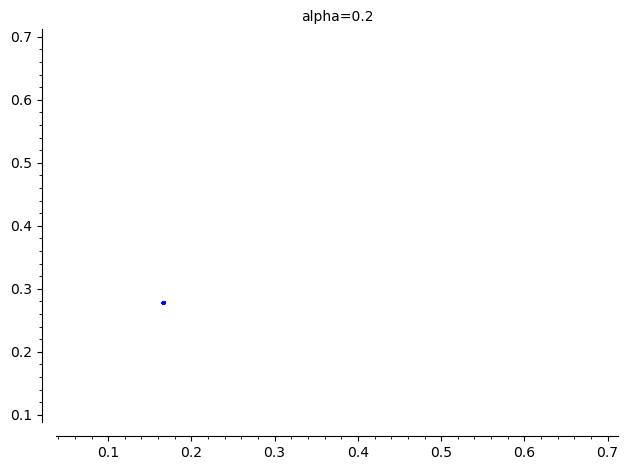

In [12]:
def trajectory_bootstrapped(alpha_value, ic):
    t_span = (0, 500)
    t_eval = np.linspace(*t_span, 2500)
    sol = solve_ivp(system, t_span, ic, t_eval=t_eval, args=(alpha_value,))
    r_vals, f_vals = sol.y
    return line(zip(r_vals[2000:], f_vals[2000:]), ymin=0.1, ymax=0.7, xmin=0.05, xmax=0.7, title=f'alpha={alpha_value}'), (r_vals[-1], f_vals[-1])

plots = []
ic = [i.subs(alpha=0.2).rhs() for i in eq]
for alpha_value in np.linspace(0.2,1.5,100):
    plot, ic = trajectory_bootstrapped(alpha_value, ic)
    plots.append(plot)

animate(plots)

In [13]:
t_max = 10000
t_span = (0, t_max)
alpha_function = lambda t: 0.2 + 1.3 * t / t_max

def system(t, y):
    r, f = y
    alpha_t = alpha_function(t)
    dr_dt = (1 - r) * r - (r * f) / (0.3 + alpha_t * r)
    df_dt = -0.5 * f + (r * f) / (0.3 + alpha_t * r)
    return [dr_dt, df_dt]

ic = [i.subs(alpha=0.2).rhs() for i in eq]
t_eval = np.linspace(*t_span, t_max*10)
sol = solve_ivp(system, t_span, ic, t_eval=t_eval)
r_vals, f_vals = sol.y
alpha_vals = [alpha_function(t) for t in sol.t]

In [14]:
line3d(zip(r_vals,f_vals,alpha_vals))

Graphics3d Object

We can see a stable limit cycle, thus the Hopf bifurcations are supercritical.

# 2. Cantor Set as a Bernoulli process

In [15]:
def bp(ic, n):
    x = [ic]
    for i in range(n):
        if random() < 0.5:
            x.append(x[-1]/3)
        else:
            x.append((x[-1]+2)/3)
    return x

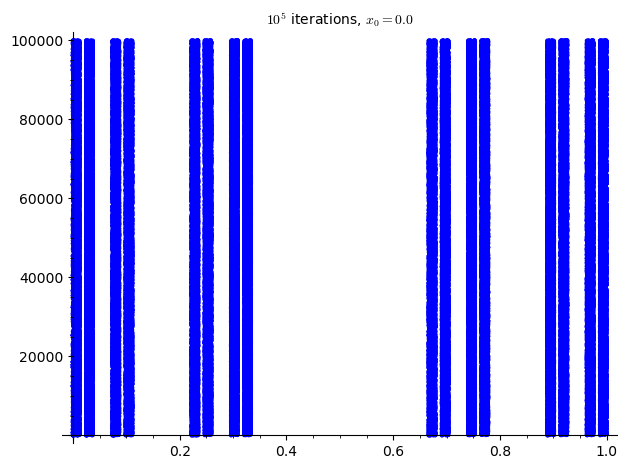

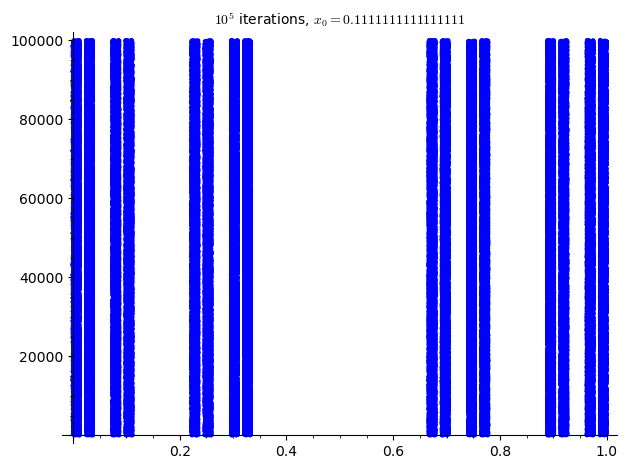

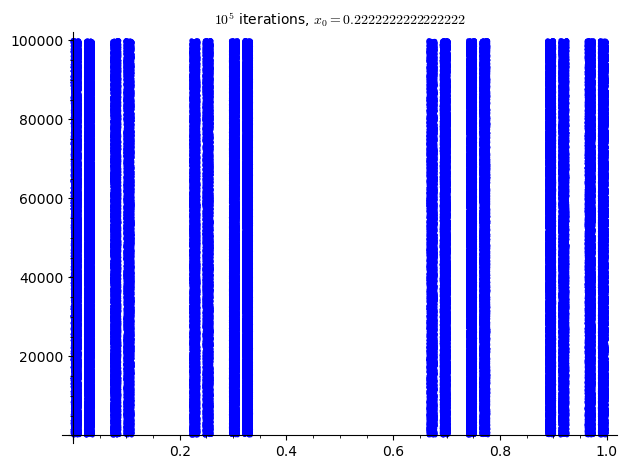

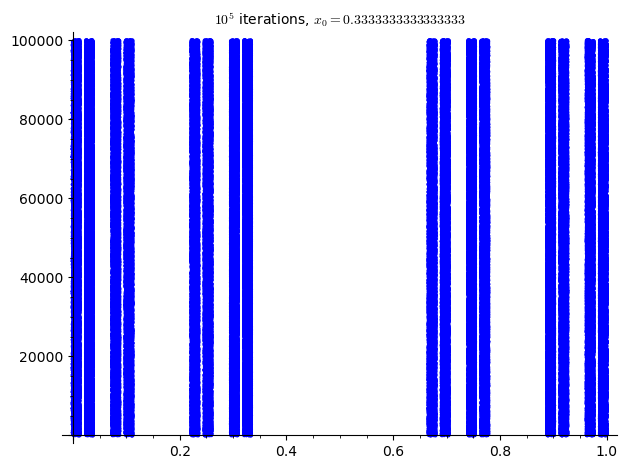

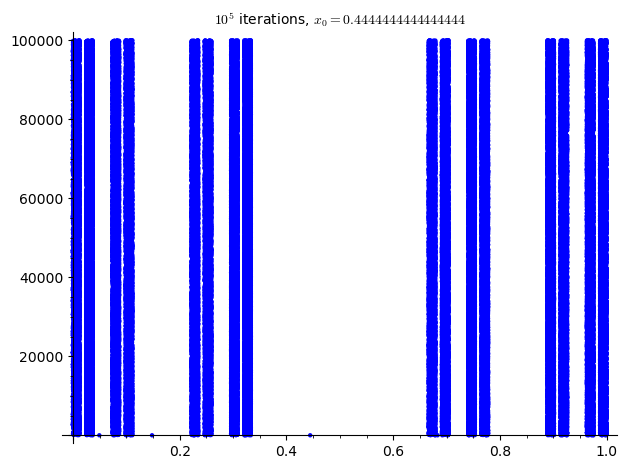

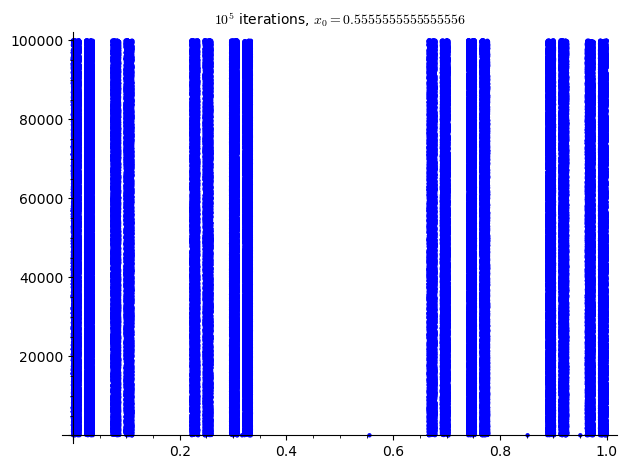

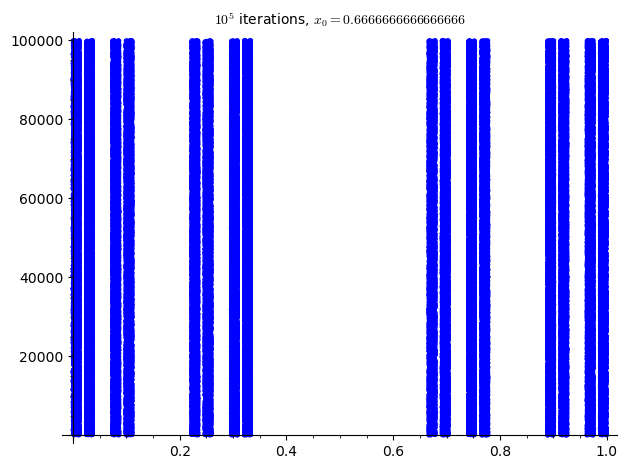

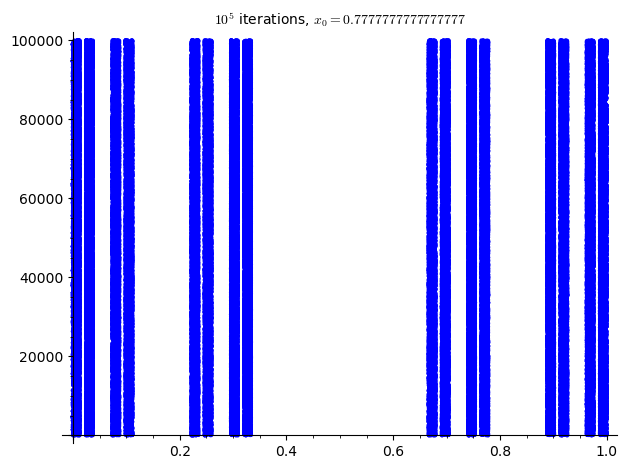

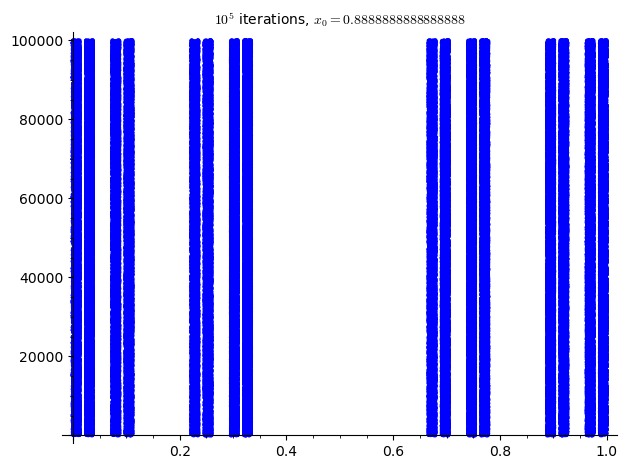

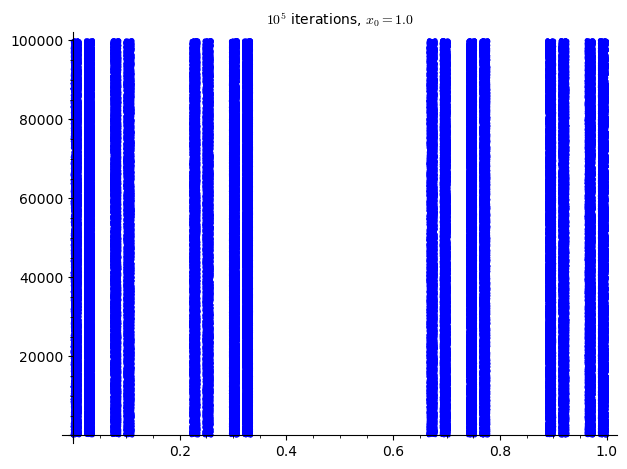

In [16]:
p = 5
n = 10**p
for ic in np.linspace(0,1,10):
    show(points(zip(bp(ic, n), range(n)), title=f'$10^{p}$ iterations, $x_0 = {ic}$'))

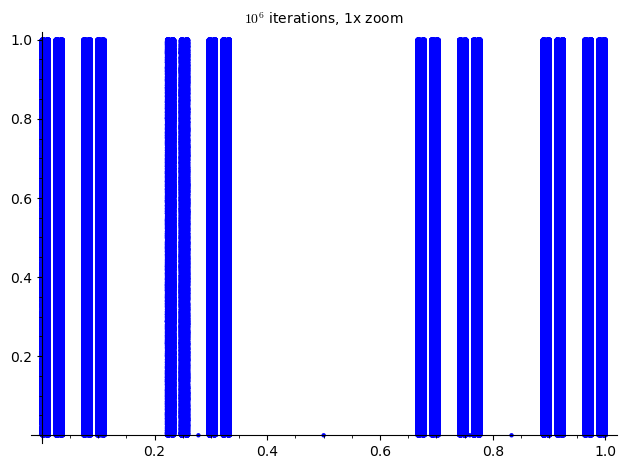

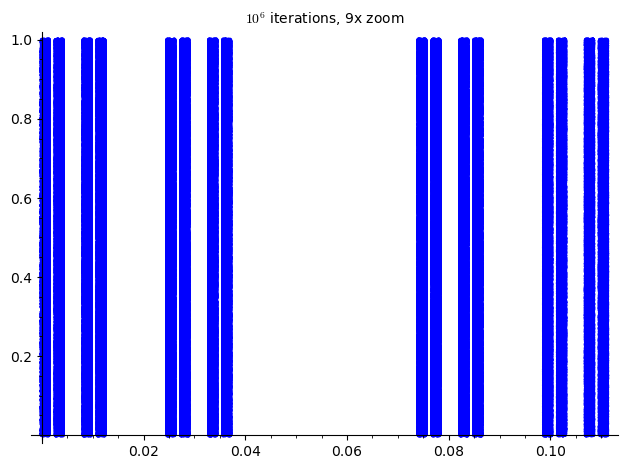

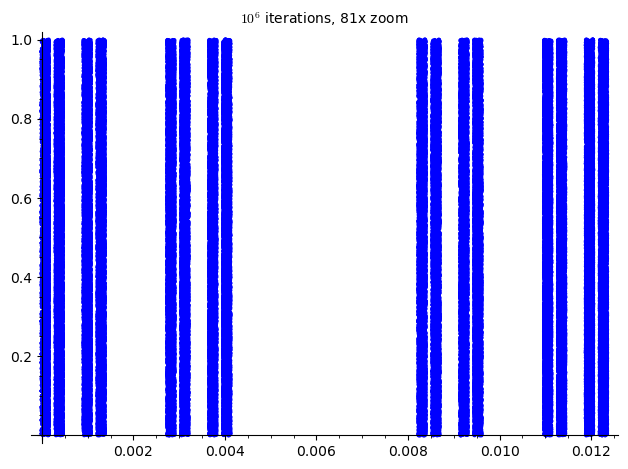

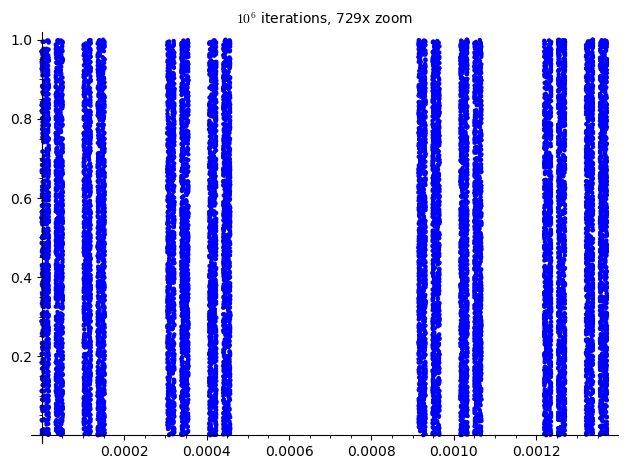

In [17]:
p = 6
n = 10**p
x = bp(0.5, n)
for k in range(0,8,2):
    show(points(zip(x, range(n)), xmin = 0, xmax = 3**(-k), title=f'$10^{p}$ iterations, {3**k}x zoom'))

# 3. Cantor Set and the Tent Map

In [18]:
def tm(ic, n, mu):
    x = [ic]
    for i in range(n):
        x.append(mu*min(x[-1],1-x[-1]))
    return x

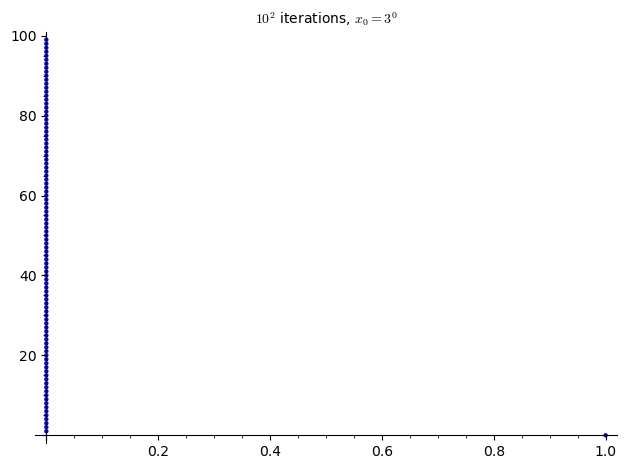

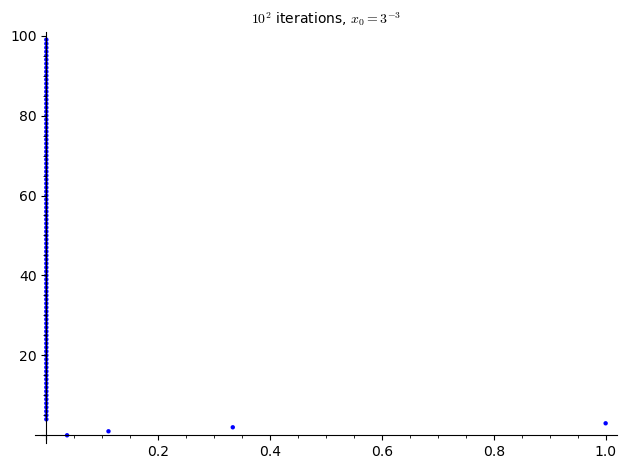

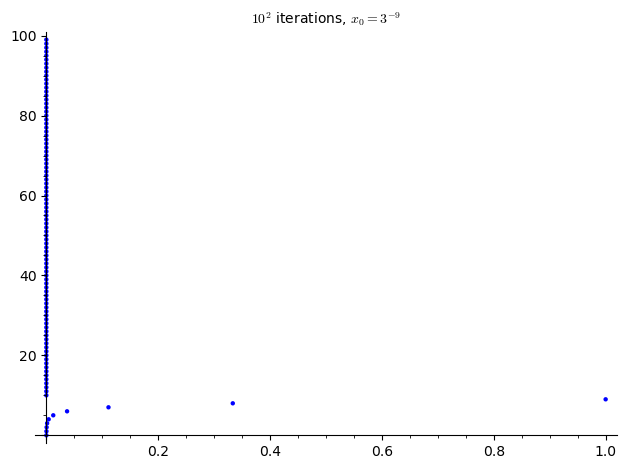

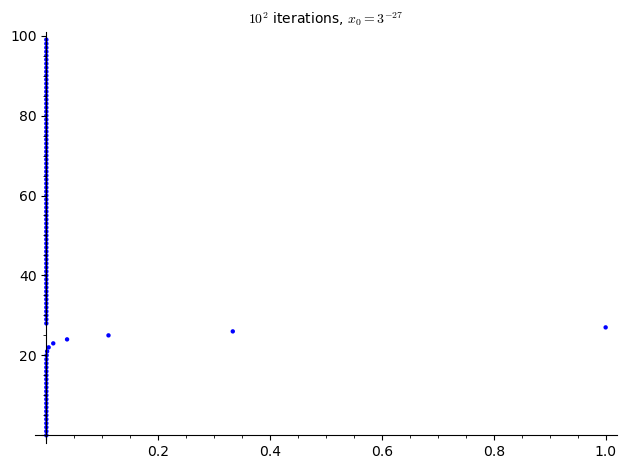

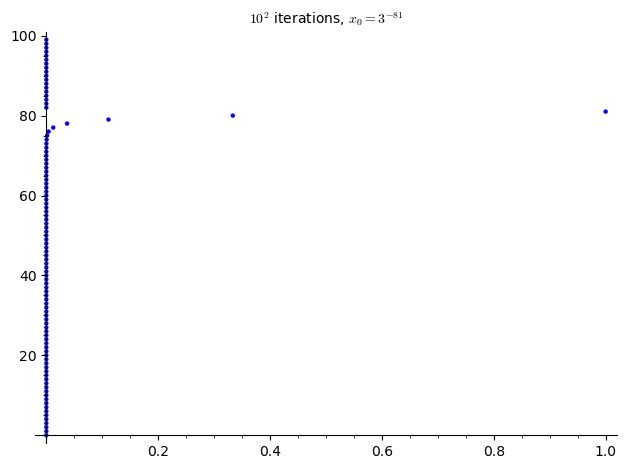

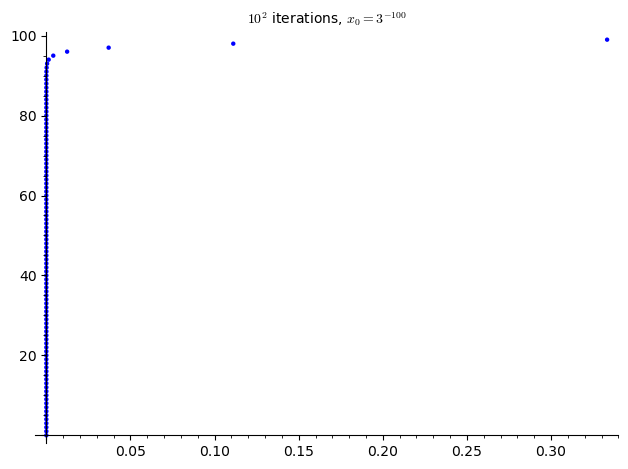

In [19]:
p = 2
n = 10**p
for k in [0,3,9,27,81,100]:
    k = -k
    show(points(zip(tm(3**k, n, 3), range(100)), title=f'$10^{p}$ iterations, $x_0 = 3^{{{k}}}$'))

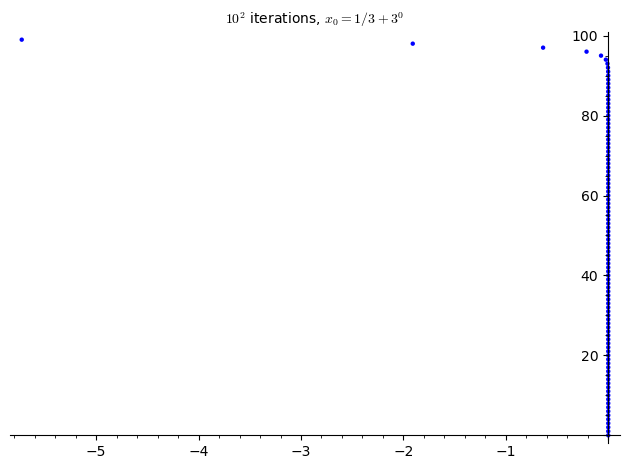

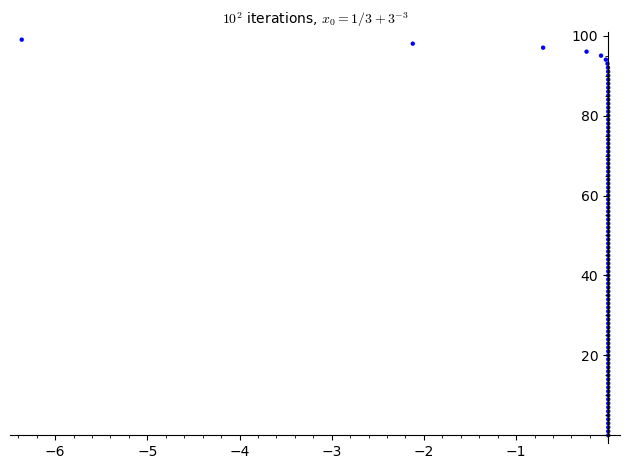

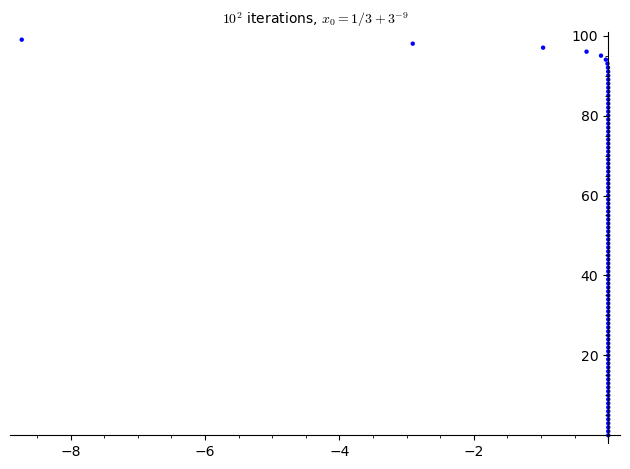

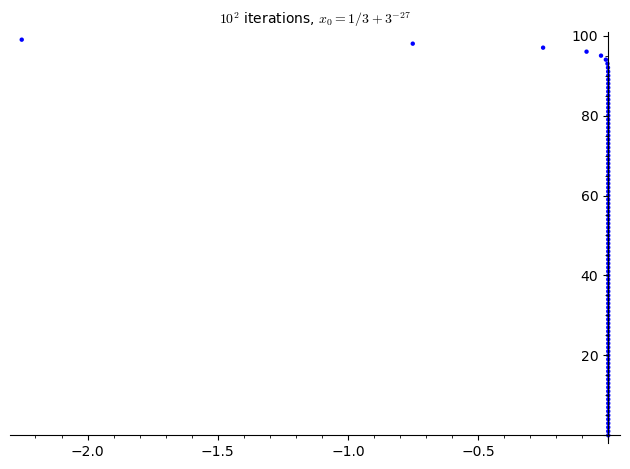

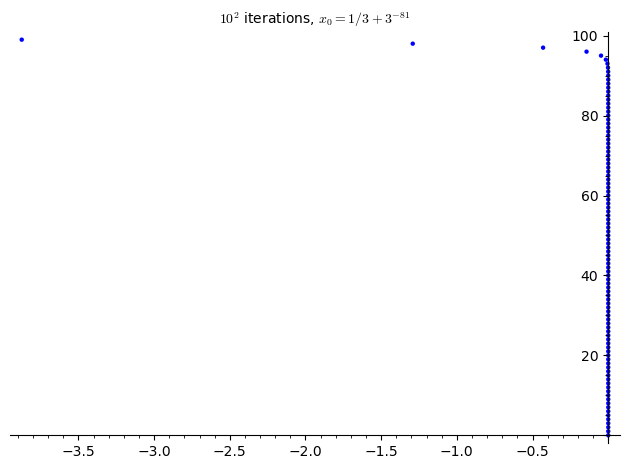

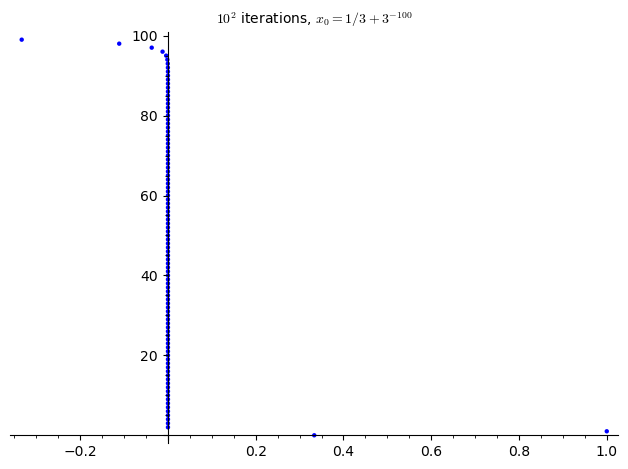

In [20]:
p = 2
n = 10**p
for k in [0,3,9,27,81,100]:
    k = -k
    show(points(zip(tm(1/3 + 3**k, n, 3), range(100)), title=f'$10^{p}$ iterations, $x_0 = 1/3 + 3^{{{k}}}$'))

Divergence occurs when the point is not in the Cantor set.